In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import numpy as np
from time import time
import pandas as pd
from scipy.stats import norm
import seaborn as sns
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 2.5})
sns.set_style('white')


c:\Users\uz755fn\PycharmProjects\MLtraining\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\uz755fn\PycharmProjects\MLtraining\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\uz755fn\PycharmProjects\MLtraining\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\uz755fn\PycharmProjects\M

In [2]:
def blackScholesPriceTrue(S0, r, K, T, vol):
    F = S0*np.exp(-r*T)
    Strike = S0*K
    sqt = vol * np.sqrt(T)
    d1 = (np.log(F / Strike) + 0.5 * vol* vol * T)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    return n1 - Strike/F * n2

def createDataset(size):
    S0 = np.linspace(50,150, size)
    r = np.linspace(0.0,0.02, size)
    K = np.linspace(0.5,1.5, size)
    T = np.linspace(0.1,1,size)
    vol = np.linspace(0.01, 0.5, size)
    inputs = np.array(np.meshgrid(S0, r, K, T, vol)).T.reshape(-1, 5)
    options = blackScholesPriceTrue(inputs[:,0],inputs[:,1], inputs[:,2], inputs[:,3],inputs[:,4])
    columns = "spots,rates,strikes,tenors,optionPrices,vols".split(',')
    data = np.array([inputs[:, 0],inputs[:, 1], inputs[:, 2], inputs[:, 3], options, inputs[:,4]])
    data = pd.DataFrame(data=data.T, columns=columns)
    return data


In [3]:
#data = pd.read_csv("bsFrame.csv")
data = createDataset(10)
data.tail()


,spots,rates,strikes,tenors,optionPrices,vols
99995,150.0,0.011111,1.5,1.0,0.068504,0.5
99996,150.0,0.013333,1.5,1.0,0.068035,0.5
99997,150.0,0.015556,1.5,1.0,0.067569,0.5
99998,150.0,0.017778,1.5,1.0,0.067105,0.5
99999,150.0,0.020000,1.5,1.0,0.066643,0.5


In [4]:
train_data = data.sample(frac=0.8,random_state=0)
test_data = data.drop(train_data.index)
train_stats = train_data.describe()
train_stats.pop("vols")
train_stats = train_stats.transpose()

train_labels = train_data.pop('vols')
test_labels = test_data.pop('vols')

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [5]:
normed_train_data = norm(train_data)
normed_test_data = norm(test_data)


In [6]:
#sns.pairplot(train_data.loc[:500, :],diag_kind="kde")

In [7]:
model=keras.Sequential( [layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
layers.Dense(64, activation="relu"),
layers.Dense(64, activation="relu"),
layers.Dense(64, activation="relu"),
layers.Dense(1)])
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [8]:

modelFile = 'bsCalibratorModel.hdf5'
epochs = 10

checkpoint = callbacks.ModelCheckpoint(modelFile, monitor='val_loss')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
history = model.fit(normed_train_data, train_labels,
    epochs=epochs, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot(), checkpoint, reduce_lr, early_stop])



..........

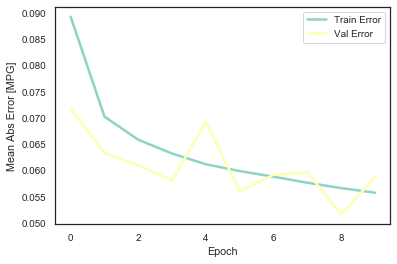

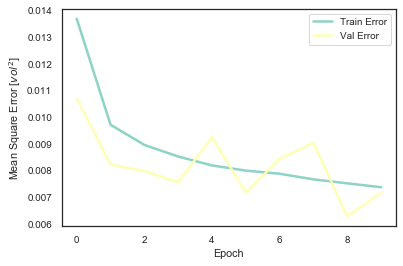

In [9]:

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.legend()
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$vol^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.legend()

  
  
plot_history(history)



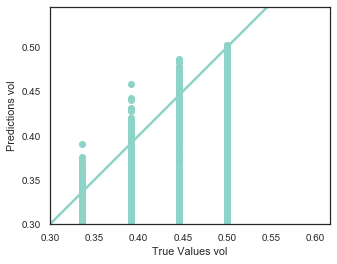

In [10]:

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values vol')
plt.ylabel('Predictions vol')
plt.axis('equal')
plt.axis('square')
plt.xlim([0.3,plt.xlim()[1]])
plt.ylim([0.3,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


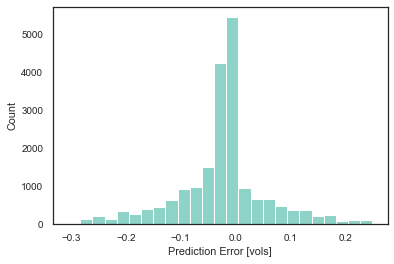

In [11]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [vols]")
_ = plt.ylabel("Count")